## 1. SETUP

### 1.1 Importar Libs

In [15]:
# Importação das bibliotecas necessárias
import sys
sys.path.append('..')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import os
import json
from joblib import load, dump
from scipy.stats import randint
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import (classification_report, confusion_matrix, 
                           accuracy_score, precision_score, recall_score, 
                           f1_score, roc_auc_score, roc_curve)
import warnings
warnings.filterwarnings('ignore')

# Importar funções dos módulos customizados
from ml_utils import gmean_score, evaluate_model, load_and_prepare_datasets
from search_utils import (multiple_randomized_search, plot_search_history, save_search_results, 
                          save_final_results, DEFAULT_CV_STRATEGY, plot_search_history_from_loaded,
                          load_search_results, get_best_params_from_saved)

# Configurações de plotagem
plt.rcParams['figure.figsize'] = [12, 8]
sns.set_style("whitegrid")

print("Bibliotecas importadas com sucesso!")
print(f"Pandas: {pd.__version__}")
print(f"NumPy: {np.__version__}")
print(f"Scikit-learn: {sklearn.__version__}")

Bibliotecas importadas com sucesso!
Pandas: 2.3.3
NumPy: 2.0.2
Scikit-learn: 1.6.1


### 1.2 Configuração do Modelo

In [16]:
# Configuração do modelo e hiperparâmetros
MODEL_NAME = "DecisionTree"
MODEL_CLASS = DecisionTreeClassifier
RANDOM_STATE_MODEL = 42
RANDOM_STATE_SAMPLE = 10

# Configuração da busca de hiperparâmetros
N_SEARCHES = 20
N_ITER_PER_SEARCH = 80
SAMPLE_SIZE = 0.10  # % of training data for hyperparameter search

# Pastas para salvamento
SEARCHES_FOLDER = 'searches'
RESULTS_FOLDER = 'results'
MODELS_FOLDER = 'models'

print(f"Modelo configurado: {MODEL_NAME}")
print(f"Classe do modelo: {MODEL_CLASS}")
print(f"Buscas: {N_SEARCHES} x {N_ITER_PER_SEARCH} iterações")

Modelo configurado: DecisionTree
Classe do modelo: <class 'sklearn.tree._classes.DecisionTreeClassifier'>
Buscas: 20 x 80 iterações


## 2. CARREGAMENTO E PREPARAÇÃO DOS DADOS

In [17]:
# Carregamento e preparação inicial dos dados
print("=== CARREGAMENTO DOS DATASETS ===")

# Carregar e preparar datasets usando função do módulo
X_train, X_test, y_train, y_test, X_train_scaled, X_test_scaled, train_data, test_data, scaler = load_and_prepare_datasets()

print(f"Dataset de treino: {train_data.shape}")
print(f"Dataset de teste: {test_data.shape}")
print(f"Features: {X_train_scaled.shape[1]}")

print("\nDistribuição das classes:")
print("Treino:", y_train.value_counts().to_dict())
print("Teste:", y_test.value_counts().to_dict())

# Mostrar sample dos dados
print("\nPrimeiras linhas do dataset de treino:")
display(train_data.head())

=== CARREGAMENTO DOS DATASETS ===
Dataset de treino: (72795, 17)
Dataset de teste: (8180, 17)
Features: 16

Distribuição das classes:
Treino: {0.0: 54175, 1.0: 18620}
Teste: {0.0: 5894, 1.0: 2286}

Primeiras linhas do dataset de treino:


,Hour,HR,O2Sat,Temp,MAP,Resp,BUN,Creatinine,Glucose,Hct,Hgb,WBC,Platelets,Gender,HospAdmTime,ICULOS,SepsisLabel
0,-0.828259,-0.396817,0.890288,-1.189896,0.268219,0.158164,0.391841,0.579093,1.632205,0.855053,0.706987,1.433318,0.068024,-1.140335,0.356849,-0.838308,0.0
1,-0.478847,-0.673800,-1.872530,0.324391,1.492201,-0.386455,-0.161934,-0.113524,-0.304515,1.156973,0.656064,-0.813046,1.079563,-1.140335,0.304841,-0.489607,0.0
2,-0.804965,0.544922,-0.644611,0.450581,1.249928,1.065862,-0.662070,-0.345514,0.976526,1.689773,1.623609,-1.137985,-0.149065,0.876935,0.357194,-0.815061,0.0
3,-0.525435,-0.396817,0.583308,-1.745135,-0.084618,0.702783,0.746309,0.543080,-1.476333,0.002573,-0.311482,-0.705572,-0.116992,0.876935,-0.584873,-0.536101,0.0
4,-0.665200,-1.061575,-0.644611,0.488439,0.387085,-0.567994,0.272113,-2.489717,-0.248842,0.748493,0.808834,-0.088417,0.940833,-1.140335,0.357194,-0.675581,0.0


## 3. SAMPLING PARA BUSCA DE HIPERPARÂMETROS

In [18]:
# ======================================================================
# SAMPLING ESTRATIFICADO PARA BUSCA DE HIPERPARÂMETROS
# ======================================================================

print("=== PREPARAÇÃO DE AMOSTRA PARA BUSCA DE HIPERPARÂMETROS ===")

# Amostra estratificada do dataset de treino
_, X_sample, _, y_sample = train_test_split(
    X_train_scaled, y_train,
    test_size=SAMPLE_SIZE,
    stratify=y_train,
    random_state=RANDOM_STATE_SAMPLE
)

print(f"Dataset original de treino: {X_train_scaled.shape[0]:,} amostras")
print(f"Amostra para busca de hiperparâmetros: {X_sample.shape[0]:,} amostras")
print(f"Redução: {(1 - X_sample.shape[0]/X_train_scaled.shape[0])*100:.1f}%")

print("\nDistribuição das classes na amostra:")
print("Amostra:", pd.Series(y_sample).value_counts().to_dict())
print("Original:", y_train.value_counts().to_dict())

=== PREPARAÇÃO DE AMOSTRA PARA BUSCA DE HIPERPARÂMETROS ===
Dataset original de treino: 72,795 amostras
Amostra para busca de hiperparâmetros: 7,280 amostras
Redução: 90.0%

Distribuição das classes na amostra:
Amostra: {0.0: 5418, 1.0: 1862}
Original: {0.0: 54175, 1.0: 18620}


## 4. DEFINIR ESTRATÉGIA DE VALIDAÇÃO CRUZADA

In [19]:
# Usar estratégia de CV padrão dos módulos
cv_strategy = DEFAULT_CV_STRATEGY
print(f"Estratégia de CV: {cv_strategy}")

Estratégia de CV: StratifiedKFold(n_splits=5, random_state=42, shuffle=True)


## 5. DECISION TREE - BUSCA DE HIPERPARÂMETROS

### 5.1 Definir Espaço de Hiperparâmetros

In [20]:
# ======================================================================
# DEFINIÇÃO DO ESPAÇO DE HIPERPARÂMETROS
# ======================================================================

# Definir hiperparâmetros específicos para Decision Tree
param_distributions = {
    'max_depth': randint(3, 50),                    # Profundidade máxima da árvore
    'min_samples_split': randint(2, 40),            # Mínimo de amostras para dividir
    'min_samples_leaf': randint(1, 50),             # Mínimo de amostras por folha
    'criterion': ['gini', 'entropy'],               # Critério de divisão
    'max_features': ['sqrt', 'log2', None],         # Número máximo de features
    'splitter': ['best', 'random']                  # Estratégia de divisão
}


### 5.2 Executar Busca de Hiperparâmetros

In [22]:
# ======================================================================
# BUSCA DE HIPERPARAMETROS
# ======================================================================

print(f"=== BUSCA DE HIPERPARÂMETROS - {MODEL_NAME} ===")
print(f"Iniciando busca de hiperparâmetros para {MODEL_NAME}...")
print(f"Executando {N_SEARCHES} buscas com {N_ITER_PER_SEARCH} iterações cada...")
print(f"Usando amostra de {X_sample.shape[0]:,} exemplos\n")

# Múltiplas execuções do RandomizedSearchCV
search, all_searches, best_params = multiple_randomized_search(
    estimator=MODEL_CLASS(random_state=RANDOM_STATE_MODEL),
    param_distributions=param_distributions,
    X=X_sample,
    y=y_sample,
    cv_strategy=cv_strategy,
    n_searches=N_SEARCHES,
    n_iter_per_search=N_ITER_PER_SEARCH,
    scoring='f1',
    random_state=None,
    n_jobs=-1
)

# Exibir os melhores resultados
print(f"\n--- RESULTADOS {MODEL_NAME} ---")
print("Melhores hiperparâmetros encontrados:")
for param, value in search.best_params_.items():
    print(f"  {param}: {value}")
print(f"\nMelhor F1-Score (CV): {search.best_score_:.4f}")
print(f"Desvio padrão: {search.cv_results_['std_test_score'][search.best_index_]:.4f}")

=== BUSCA DE HIPERPARÂMETROS - DecisionTree ===
Iniciando busca de hiperparâmetros para DecisionTree...
Executando 20 buscas com 80 iterações cada...
Usando amostra de 7,280 exemplos

Executando 20 buscas com 80 iterações cada...

Busca 1/20...
Melhor score desta busca: 0.5135
Melhor configuração desta busca: {'criterion': 'entropy', 'max_depth': 25, 'max_features': None, 'min_samples_leaf': 42, 'min_samples_split': 34, 'splitter': 'best'}
Melhor score geral até agora: 0.5135

Busca 2/20...
Melhor score desta busca: 0.5230
Melhor configuração desta busca: {'criterion': 'entropy', 'max_depth': 8, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 37, 'splitter': 'best'}
Melhor score geral até agora: 0.5230

Busca 3/20...
Melhor score desta busca: 0.5157
Melhor configuração desta busca: {'criterion': 'entropy', 'max_depth': 27, 'max_features': None, 'min_samples_leaf': 45, 'min_samples_split': 8, 'splitter': 'best'}
Melhor score geral até agora: 0.5230

Busca 4/20...
Mel

### 5.3 Visualizar Histórico da Busca

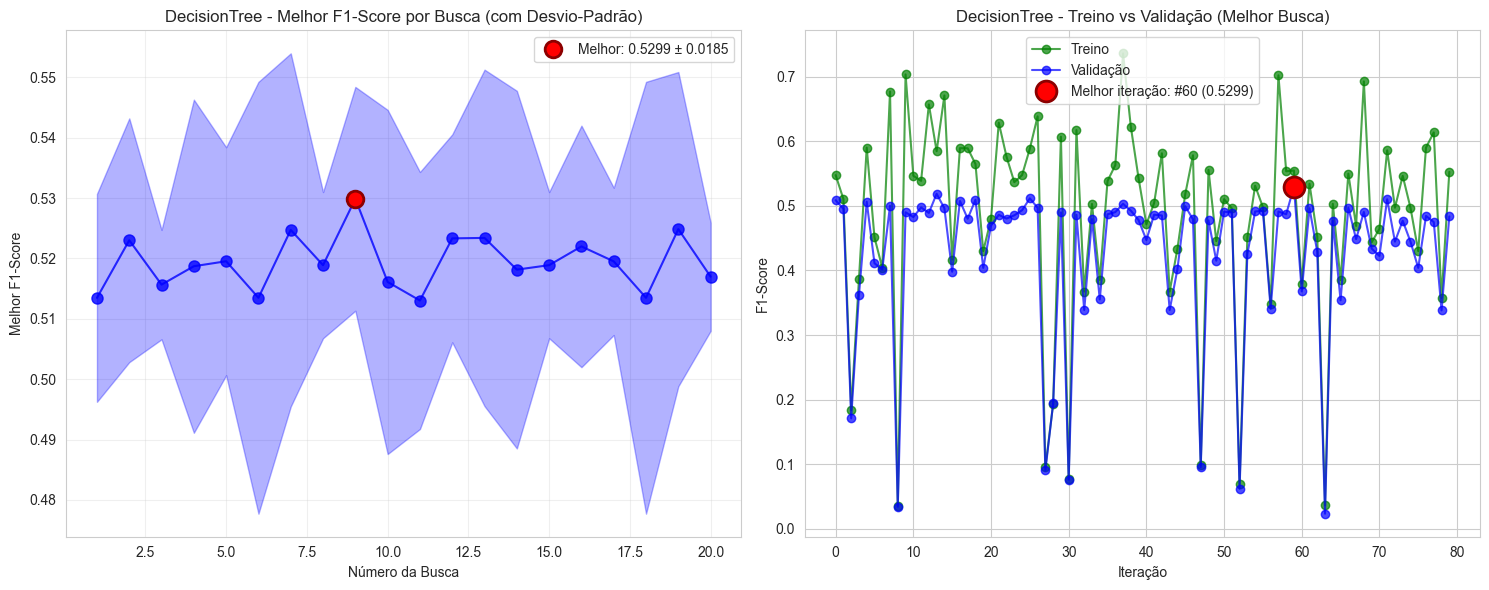

In [23]:
# Registro de Desempenho - plotar evolução da busca
plot_search_history(all_searches, search, MODEL_NAME)

In [24]:
# ======================================================================
# ANÁLISE DAS MELHORES CONFIGURAÇÕES ENCONTRADAS
# ======================================================================

print(f"=== MELHORES CONFIGURAÇÕES ENCONTRADAS POR BUSCA - {MODEL_NAME} ===")

# Extrair os melhores resultados de cada busca
best_configs = []

for i, search_result in enumerate(all_searches):
    config = {
        'Busca': i + 1,
        'F1_Score': search_result['best_score'],
        **search_result['best_params']
    }
    best_configs.append(config)

# Criar DataFrame e exibir top configs
results_df = pd.DataFrame(best_configs)
results_df = results_df.sort_values('F1_Score', ascending=False).round(4)

print(f"\nTop configurações (de {len(results_df)} buscas):")
print(results_df.to_string(index=False))

print(f"\nEstatísticas dos F1-Scores encontrados:")
print(f"  Média: {results_df['F1_Score'].mean():.4f}")
print(f"  Mediana: {results_df['F1_Score'].median():.4f}")
print(f"  Desvio padrão: {results_df['F1_Score'].std():.4f}")
print(f"  Min: {results_df['F1_Score'].min():.4f}")
print(f"  Max: {results_df['F1_Score'].max():.4f}")

=== MELHORES CONFIGURAÇÕES ENCONTRADAS POR BUSCA - DecisionTree ===

Top configurações (de 20 buscas):
 Busca  F1_Score criterion  max_depth max_features  min_samples_leaf  min_samples_split splitter
     9    0.5299   entropy          5         None                35                 12     best
    19    0.5249   entropy          5         None                48                  5     best
     7    0.5247      gini          5         None                44                 36     best
    13    0.5234   entropy          8         sqrt                 7                 31     best
    12    0.5233   entropy         13         None                 1                 15     best
     2    0.5230   entropy          8         log2                 1                 37     best
    16    0.5220   entropy          5         None                15                 12     best
     5    0.5195   entropy         14         None                 1                  2     best
    17    0.5195      gi

## 6. SALVAR RESULTADOS DE BUSCA

In [25]:

search_df = save_search_results(
    model_name=MODEL_NAME,
    model_search=search,
    model_all_searches=all_searches,
    n_searches=N_SEARCHES,
    n_iter_per_search=N_ITER_PER_SEARCH,
    scoring='f1',
    cv_folds=5,
    top_params_columns=['max_depth', 'min_samples_split', 'min_samples_leaf', 'criterion', 'max_features'],
    searches_folder=SEARCHES_FOLDER
)

=== SALVANDO RESULTADOS DA BUSCA - DECISIONTREE ===
  ✅ Todos os Resultados salvos: searches/decisiontree_all_searches.csv
  Total de configurações testadas: 1,600
  ✅ Resumo salvo: searches/decisiontree_search_summary.json

--- ESTATÍSTICAS DA BUSCA DECISIONTREE ---
Melhor F1-Score: 0.5299
Desvio padrão do melhor: 0.0185
F1-Score médio geral: 0.4250
F1-Score mínimo: 0.0085
F1-Score máximo: 0.5299


### 6.2 Carregar Resultado de Busca (Opcional)

In [26]:
loaded_results = load_search_results(MODEL_NAME)

=== CARREGANDO RESULTADOS DE BUSCA - DECISIONTREE ===
✅ Resultados detalhados carregados: 1,600 configurações
✅ Resumo carregado: F1-Score = 0.5299
⚠️  Arquivo não encontrado: searches/decisiontree_full_search.pkl


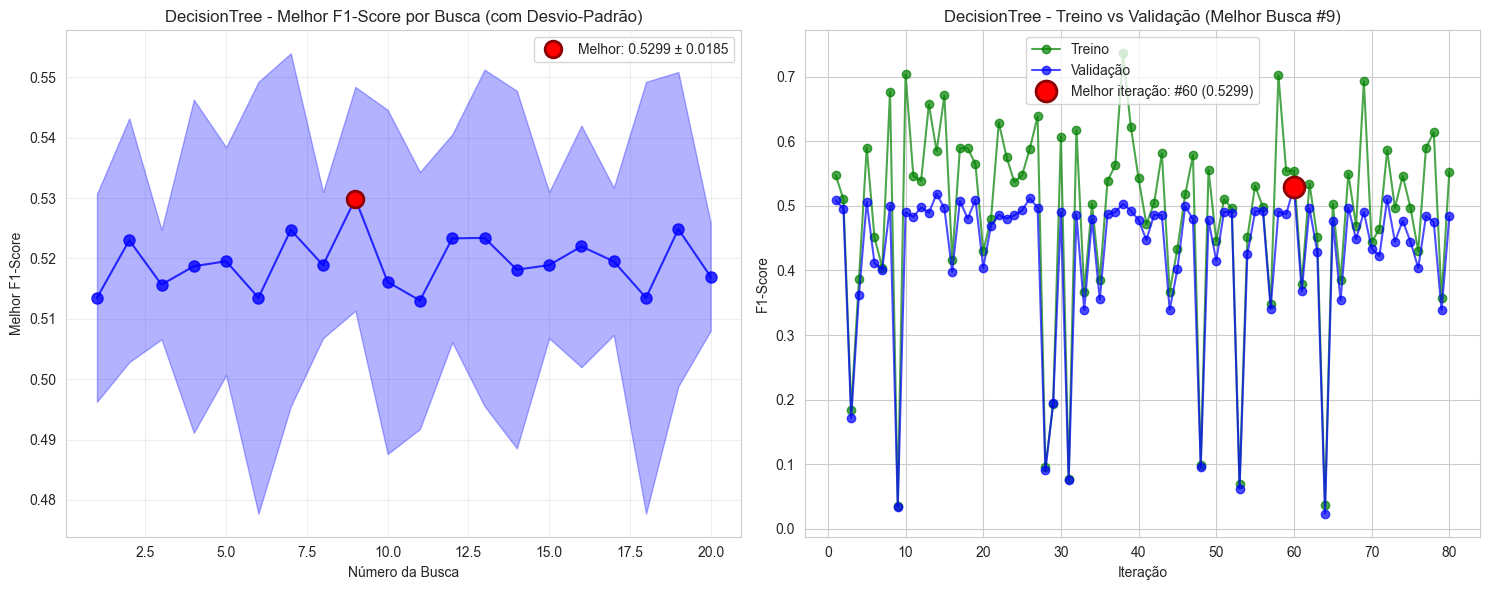

In [27]:
# Plotar a história da busca a partir dos resultados carregados
plot_search_history_from_loaded(loaded_results, MODEL_NAME)

### 6.3 Definir Melhores Params e CV score

In [28]:
# Definir Melhores Parâmetros para Uso Posterior
if 'loaded_results' in locals():
    best_params = get_best_params_from_saved(MODEL_NAME)
    if best_params:
        print(f"✅ Parâmetros carregados: {best_params}")
    best_score = loaded_results['summary']['best_overall_score']
    print(f"✅ Melhor F1-Score carregado: {best_score:.4f}")
else:
    best_params = search.best_params_
    best_score = search.best_score_
    print(f"✅ Usando parâmetros da busca atual: {best_params}")
    print(f"✅ Melhor F1-Score da busca atual: {best_score:.4f}")

✅ Parâmetros carregados: {'criterion': 'entropy', 'max_depth': 5, 'max_features': None, 'min_samples_leaf': 35, 'min_samples_split': 12, 'splitter': 'best'}
✅ Melhor F1-Score carregado: 0.5299


## 7. TREINAR MODELO FINAL E SALVAR

In [29]:
# Treinamento Final com melhores hiperparâmetros

best_model = MODEL_CLASS(random_state=RANDOM_STATE_MODEL, **best_params)
best_model.fit(X_train_scaled, y_train)


DecisionTreeClassifier(criterion='entropy', max_depth=5, min_samples_leaf=35,
                       min_samples_split=12, random_state=42)

In [30]:

# Save the trained model immediately after training
os.makedirs(MODELS_FOLDER, exist_ok=True)

model_path = os.path.join(MODELS_FOLDER, f'{MODEL_NAME.lower().replace(" ", "_")}_model.joblib')
dump(best_model, model_path)
print(f"✅ Model saved to: {model_path}")

✅ Model saved to: models/decisiontree_model.joblib


## 8. AVALIAÇÃO FINAL E SALVAMENTO DOS RESULTADOS

In [31]:
# Carregar modelo (Opcional)
loaded_model = load(f'models/{MODEL_NAME.lower()}_trained.joblib')

FileNotFoundError: [Errno 2] No such file or directory: 'models/decisiontree_trained.joblib'

In [32]:
print(f"=== AVALIAÇÃO E SALVAMENTO DOS RESULTADOS - {MODEL_NAME} ===")

# Criar pastas se não existirem
os.makedirs(RESULTS_FOLDER, exist_ok=True)

# Avaliação completa do modelo
print("\nAvaliando performance do modelo...")

# Usar datasets completos para avaliação final
X_train_eval = X_train_scaled
y_train_eval = y_train
X_test_eval = X_test_scaled
y_test_eval = y_test

# Avaliar modelo usando função do módulo
train_metrics, test_metrics, y_test_pred = evaluate_model(
    best_model, X_train_eval, X_test_eval, y_train_eval, y_test_eval, MODEL_NAME
)

=== AVALIAÇÃO E SALVAMENTO DOS RESULTADOS - DecisionTree ===

Avaliando performance do modelo...


In [33]:
classification_report(y_test, y_test_pred, zero_division=0)

'              precision    recall  f1-score   support\n\n         0.0       0.82      0.92      0.86      5894\n         1.0       0.69      0.48      0.56      2286\n\n    accuracy                           0.79      8180\n   macro avg       0.75      0.70      0.71      8180\nweighted avg       0.78      0.79      0.78      8180\n'

### 8.2 Visualize Confusion Matrix

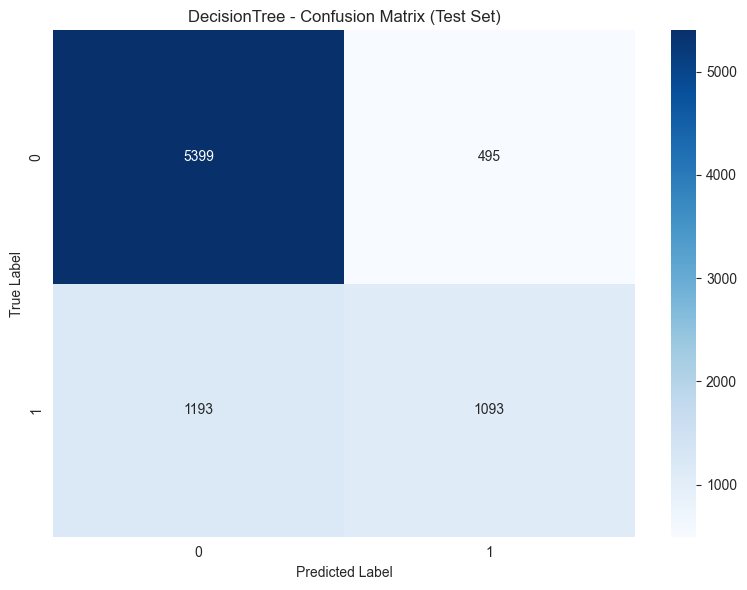

In [34]:
# Plot confusion matrix
cm = confusion_matrix(y_test, y_test_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True)
plt.title(f'{MODEL_NAME} - Confusion Matrix (Test Set)')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

### 8.3 Save Final Results

In [35]:
# Salvar resultados finais usando função do módulo
model_final_results = save_final_results(
    model_name=MODEL_NAME,
    best_params=best_params,
    best_score=best_score,
    train_metrics=train_metrics,
    test_metrics=test_metrics,
    y_pred=y_test_pred,
    y_test=y_test_eval,
    X_train_scaled=X_train_eval,
    X_test_scaled=X_test_eval,
    results_folder=RESULTS_FOLDER
)

# Mostrar resumo final
print(f"\n--- RESUMO FINAL {MODEL_NAME} ---")
print(f"F1-Score CV: {model_final_results['best_cv_score']:.4f}")
print(f"F1-Score Teste: {test_metrics['f1']:.4f}")
print(f"Acurácia Teste: {test_metrics['accuracy']:.4f}")
print(f"Precisão Teste: {test_metrics['precision']:.4f}")
print(f"Recall Teste: {test_metrics['recall']:.4f}")
print(f"G-Mean Teste: {test_metrics['gmean']:.4f}")
if test_metrics.get('auc_roc'):
    print(f"AUC-ROC Teste: {test_metrics['auc_roc']:.4f}")

print(f"\nAvaliação do {MODEL_NAME} concluída com sucesso!")
print(f"Resultados salvos em: {RESULTS_FOLDER}/")
print(f"Modelo salvo em: {MODELS_FOLDER}/")
print(f"Histórico de busca salvo em: {SEARCHES_FOLDER}/")

✅ Resultados DecisionTree salvos em: results/decisiontree_results.json

--- RESUMO FINAL DecisionTree ---
F1-Score CV: 0.5299
F1-Score Teste: 0.5643
Acurácia Teste: 0.7936
Precisão Teste: 0.6883
Recall Teste: 0.4781
G-Mean Teste: 0.6618
AUC-ROC Teste: 0.7680

Avaliação do DecisionTree concluída com sucesso!
Resultados salvos em: results/
Modelo salvo em: models/
Histórico de busca salvo em: searches/
